In [1]:
import os
import glob
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import time
import PIL
import imageio

from IPython import display

import tensorflow as tf
from tensorflow.keras import datasets, layers, Sequential, Model
from tensorflow.keras import metrics
from tensorflow.keras import constraints

tf.__version__

'2.1.0'

In [2]:
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# On DGX-1 you might need to set the following environment variable for maximum performance:
os.environ['NCCL_TOPOLOGY'] = 'CUBEMESH'

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

# Data

In [4]:
num_disc = 5

## load minst data

In [5]:
# x: [60k, 28, 28],
# y: [60k]
(train_MNIST, train_labels), (test_MNIST, test_labels) = datasets.mnist.load_data()
train_images = train_MNIST.reshape(train_MNIST.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
test_images = test_MNIST.reshape(test_MNIST.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

## split to target and shadow

In [6]:
target_size = 7000
target_images = train_images[:target_size]

In [7]:
def EvenlySplitting(dataset, size=5):
    chunk_size = dataset.shape[0]//size
    
    splitted_datasets = []
    for i in range(size):
        temp_data = dataset[i*chunk_size:(i+1)*chunk_size]
        splitted_datasets.append(temp_data)
        
    return splitted_datasets

In [8]:
train_datasets = EvenlySplitting(target_images, size=num_disc)

In [9]:
len(train_datasets)

5

In [10]:
train_datasets[0].shape

(1400, 28, 28, 1)

# Build GAN

In [11]:
noise_dim = 100
nrow = target_images.shape[1]
ncol = target_images.shape[2]
channels = target_images.shape[3]
input_shape = (nrow, ncol, channels)

## Generator

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256
                                  )  # Note: None is the batch size

    model.add(
        layers.Conv2DTranspose(128, (5, 5),
                               strides=(1, 1),
                               padding='same',
                               use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(64, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(1, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False,
                               activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

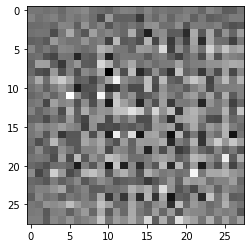

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(
        layers.Conv2D(64, (5, 5),
                      strides=(2, 2),
                      padding='same',
                      input_shape=[28, 28, 1]))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(
        layers.Conv2D(128, (5, 5),
                      strides=(2, 2),
                      padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [15]:
# Use the (as yet untrained) discriminator 
# to classify the generated images as real or fake.
discriminators = []
for i in range(num_disc):
    discriminators.append(make_discriminator_model())

In [16]:
# check output, two outputs are different, which means discriminators are independent.
for i in range(num_disc):
    disc_output = discriminators[0](generated_image, training=False)
    print (disc_output)

tf.Tensor([[0.49980256]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49980256]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49980256]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49980256]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49980256]], shape=(1, 1), dtype=float32)


## Loss

In [17]:
# cross_entropy_loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer

In [18]:
# # Learning Rate for DISCRIMINATOR
# LR_DISC = tf.compat.v1.train.polynomial_decay(learning_rate=1e-2,
#                                               global_step=tf.compat.v1.train.get_or_create_global_step(),
#                                               decay_steps=10000,
#                                               end_learning_rate=1e-5,
#                                               power=0.5,
#                                               cycle=True)

# generator_optimizer = tf.keras.optimizers.Adam(LR_DISC, beta_1=0.5, beta_2=0.999)
# discriminator_optimizer=tf.keras.optimizers.Adam(LR_DISC, beta_1=0.5, beta_2=0.999)

In [19]:
# # # RMSprop
# generator_optimizer = tf.keras.optimizers.RMSprop(LR_DISC)
# discriminator_optimizer = tf.keras.optimizers.RMSprop(LR_DISC)

In [20]:
# Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

# Training

In [21]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # plt.savefig('images/DF-DCGAN-{}-Disc-{}-epoch{:05d}.png'.format(train_datasets.shape[0], num_disc, epoch))
    plt.show()

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch_size, zipped_image_batch):
    # iterations of the critic per generator interation
    for _ in range(2):
        all_disc_loss = []
        # for each discriminator
        for i in range(num_disc):            
            noise = tf.random.normal([batch_size, noise_dim])
            with tf.GradientTape() as disc_tape:            
                generated_images = generator(noise, training=True)
                real_output = discriminators[i](zipped_image_batch[i], training=True)
                fake_output = discriminators[i](generated_images, training=True)

                disc_loss = discriminator_loss(real_output, fake_output)

                gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminators[i].trainable_variables)
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                            discriminators[i].trainable_variables))
            all_disc_loss.append(disc_loss)
    
    # iterations of the G per D interation
    for _ in range(1):
        with tf.GradientTape() as gen_tape:
            all_gen_loss = []
            for i in range(num_disc):
                noise = tf.random.normal([batch_size, noise_dim])
                generated_images = generator(noise, training=True)
                fake_output = discriminators[i](generated_images, training=True)        
                gen_loss = generator_loss(fake_output)
                
                all_gen_loss.append(gen_loss)
        
            avg_gen_loss = tf.reduce_mean(all_gen_loss)
            gradients_of_generator = gen_tape.gradient(avg_gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))   
              
    return avg_gen_loss, all_disc_loss

In [24]:
def train(train_datasets, epochs, batch_size):
    # Batch and shuffle all datasets
    train_batches = []
    for i in range(num_disc):
        train_batches.append(
            tf.data.Dataset.from_tensor_slices(train_datasets[i]).shuffle(
                train_datasets[i].shape[0]).batch(batch_size,
                                                  drop_remainder=True))

    gen_loss_log, disc_loss_log = [], []
    for epoch in range(epochs):
        start = time.time()

        for zipped_image_batch in zip(*train_batches):
            gen_loss, all_disc_loss = train_step(batch_size, zipped_image_batch)
        # append loss of last batch
        gen_loss_log.append(gen_loss.numpy())
        disc_loss_log.append(all_disc_loss)
        
        if (epoch + 1) % 100 == 0:
            # Produce images for the GIF
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)

        # Save the model
        if (epoch + 1) % 500 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # print loss of last batch
        print('Epoch {}, gen_loss: {:.5f}, disc_loss: {}. Time: {:.2f} sec'.format(epoch + 1,
            gen_loss.numpy(), [loss.numpy() for loss in all_disc_loss], time.time() - start))      

    return gen_loss_log, disc_loss_log

In [25]:
checkpoint_dir = './training_checkpoints/PAR-DCGAN-{}-Disc-{}'.format(
    target_images.shape[0], num_disc)
checkpoint_prefix = os.path.join(checkpoint_dir, "2-1-avg")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator0=discriminators[0],
    discriminator1=discriminators[1])

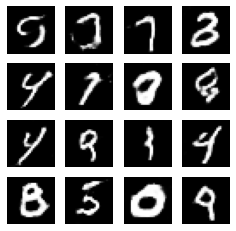

gen_loss: 0.6410282850265503, disc_loss: [1.1630943, 1.1795192, 1.1809659, 1.2099108, 1.1668996]
Time for epoch 1500 is 1.832085371017456 sec


In [26]:
EPOCHS = 1500
BATCH_SIZE = 64
gen_loss_log, disc_loss_log = train(train_datasets,
                                    epochs=EPOCHS,
                                    batch_size=BATCH_SIZE)

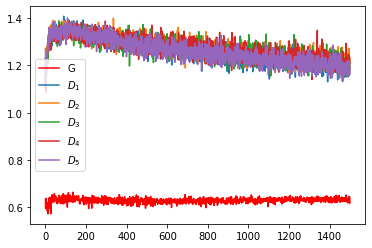

In [27]:
# loss curve
# generator
plt.plot(range(len(gen_loss_log)), gen_loss_log, 'r', label='G')

# discriminator
disc_loss_array = np.asarray(disc_loss_log)
for i in range(num_disc):
    plt.plot(range(disc_loss_array.shape[0]), disc_loss_array[:,i], label='$D_{}$'.format(i+1))

plt.legend()
plt.show()

## Check storing point

In [48]:
# load checkpoint
storing_point = tf.train.latest_checkpoint(checkpoint_dir)
# storing_point = './training_checkpoints/PAR-DCGAN-7000-Disc-5/2-1-avg-19'
print(storing_point)
checkpoint.restore(storing_point)

./training_checkpoints/PAR-DCGAN-7000-Disc-5/2-1-avg-3


In [47]:
for i in range(3):
    # load checkpoint
    storing_point = './training_checkpoints/PAR-DCGAN-7000-Disc-5/2-1-avg-{}'.format(i+1)
    print(storing_point)
    checkpoint.restore(storing_point)
    
    target_loss, holdout_loss = [], []
    for j in range(num_disc):
        target_output = discriminators[j](target_images, training=False)
        holdout_output = discriminators[j](test_images[:target_size], training=False)

        target_loss.append(cross_entropy(tf.ones_like(target_output), target_output))
        holdout_loss.append(cross_entropy(tf.ones_like(holdout_output), holdout_output))

    print(tf.reduce_mean(target_loss).numpy(), 
          tf.reduce_mean(holdout_loss).numpy(), 
          abs(tf.reduce_mean(target_loss) - tf.reduce_mean(holdout_loss).numpy()))

./training_checkpoints/PAR-DCGAN-7000-Disc-5/2-1-avg-1
0.5302108 0.5368092 tf.Tensor(0.006598413, shape=(), dtype=float32)
./training_checkpoints/PAR-DCGAN-7000-Disc-5/2-1-avg-2
0.5282651 0.5405602 tf.Tensor(0.012295067, shape=(), dtype=float32)
./training_checkpoints/PAR-DCGAN-7000-Disc-5/2-1-avg-3
0.5238681 0.5388142 tf.Tensor(0.014946103, shape=(), dtype=float32)


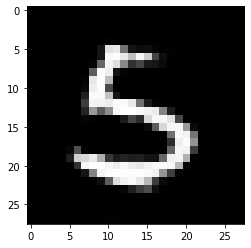

In [35]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [36]:
for i in range(num_disc):
    disc_output = discriminators[i](generated_image, training=False)
    print (disc_output)

tf.Tensor([[0.00368478]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.38516408]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.49796933]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.512034]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.50660855]], shape=(1, 1), dtype=float32)


## Synthetic samples

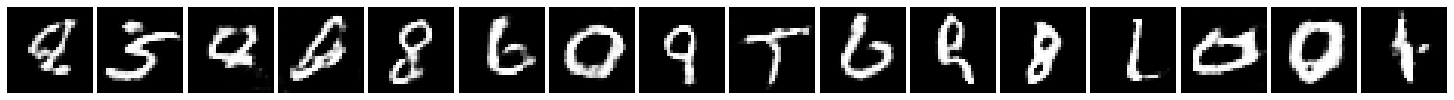

In [37]:
def generate_and_save_images(model, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(20, 16))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 16, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0, right=1, bottom=0, top=1)
#     plt.savefig('../../plot_figures/MNIST-PAR-DCGAN-Size7000-Disc5.svg',format='svg')
    plt.show()
    
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator, seed)

# Quatitative evaluation 

In [40]:
# generate images for evaluation
num_generated_images = target_size # same size with target dataset
generated_images = np.empty((0, 28, 28, 1), float)
for i in range(num_generated_images//1000):
    noise = tf.random.normal([1000, 100])
    generated_image = generator(noise, training=False) # * 127.5 + 127.5
    
    generated_images= np.vstack([generated_images, generated_image])

In [41]:
generated_images.shape

(7000, 28, 28, 1)

## FID

In [42]:
import os
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from skimage.transform import resize
from sklearn import metrics as sklearn_metrics

In [43]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [44]:
# prepare the inception v3 model
model = InceptionV3(include_top=False,
                    pooling='avg',
                    input_shape=(299, 299, 3))

In [45]:
# convert integer to floating point values
images1 = (test_MNIST[:target_size].astype('float32') - 127.5) / 127.5
images2 = generated_images.astype('float32')

# resize images
images1 = scale_images(images1, (299, 299, 3))
images2 = scale_images(images2, (299, 299, 3))
print('Scaled', images1.shape, images2.shape)

Scaled (7000, 299, 299, 3) (7000, 299, 299, 3)


In [46]:
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
# fid = calculate_fid(model, images1, images1)
# print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

FID (different): 4.086


# MIA

## Attack on discriminiator 

In [49]:
def WBattack_priv(X,X_comp, discriminators):
    
    Dat = np.concatenate([X, X_comp])
    Pred = []
    
    for i in range(len(discriminators)):
        Pred += [discriminators[i].predict(Dat)[:,0]]
        
    
    p_mean = np.mean(Pred, axis = 0)
    p_max = np.max(Pred, axis = 0)
    
    In_mean = np.argsort(-p_mean)
    In_mean = In_mean[:len(X)]

    In_max = np.argsort(-p_max)
    In_max = In_max[:len(X)]
    
    Acc_max = np.sum(1.*(In_max<len(X)))/len(X)
    Acc_mean = np.sum(1.*(In_mean<len(X)))/len(X)
    
    print('White-box attack accuracy (max):',Acc_max)
    print('White-box attack accuracy (mean):',Acc_mean)
    
    return(Acc_max, Acc_mean)

In [50]:
#perform white box attack
WBattack_priv(target_images, test_images[:target_size], discriminators)

White-box attack accuracy (max): 0.591
White-box attack accuracy (mean): 0.5622857142857143


(0.591, 0.5622857142857143)

## TVD

In [51]:
def WBattack_TVD_priv(X,X_comp, discriminators):
    
    tvd = []
    
    for i in range(len(discriminators)):
        n1, _= np.histogram(discriminators[i].predict(X)[:,0], bins = 50, density = True, range = [0,1])
        n2, _ = np.histogram(discriminators[i].predict(X_comp)[:,0], bins = 50, density = True, range = [0,1])
        tvd += [0.5*np.linalg.norm(n1-n2,1)/50.0]
    
    print('Total Variational Distance - max:',max(tvd))
    print('Total Variational Distance - mean:',np.mean(tvd))
    
    return(np.max(tvd),np.mean(tvd)) 

In [52]:
WBattack_TVD_priv(target_images, test_images[:target_size], discriminators)

Total Variational Distance - max: 0.17357143520525997
Total Variational Distance - mean: 0.09617142601129007


(0.17357143520525997, 0.09617142601129007)

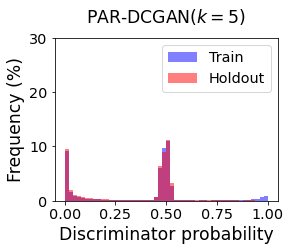

In [30]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {
    'figure.figsize': (4, 3),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'xx-large',
    'axes.titlesize': 'xx-large',
    'axes.titlepad': 15,
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

def get_predict_results(dataset):
    results = []
    for i in range(num_disc):
        results.append(discriminators[i].predict(dataset))
    results = tf.concat(results, axis=0)
    
    return results

#plot distribution of discriminator scores of training and test set
plt.hist(get_predict_results(target_images)[:, 0],
         color='b',
         alpha=0.5,
         label='Train',
         density=True,
         bins=50)
plt.hist(get_predict_results(test_images[:target_size])[:, 0],
         color='r',
         alpha=0.5,
         label='Holdout',
         density=True,
         bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Frequency (%)')
plt.ylim(ymax=30)
plt.title('PAR-DCGAN($k=5$)')
plt.legend()

plt.savefig('plot_figures/PAR-DCGAN_k5.svg', format='svg')
plt.show()

## Attack on generator 

In [29]:
from sklearn.decomposition import PCA

In [30]:
def MC_eps_attack(X, X_comp, X_ho, generator, N = 10000, M = 100, n_pc = 40, reps = 50):
    
    #flatten images 
    if len(X.shape)==3:
        sh = X.shape[1]*X.shape[2]        
    elif len(X.shape)==2:
        sh = X.shape[1]
    else:
        sh = X.shape[1]*X.shape[2]*X.shape[3]
        
    X = np.reshape(X, (len(X),sh))
    X_comp = np.reshape(X_comp, (len(X_comp),sh))
    X_ho = np.reshape(X_ho, (len(X_ho),sh))
    
    #fit PCA
    pca = PCA(n_components=n_pc)
    pca.fit(X_ho)
        
    res = []
    
    for r in range(reps):
        
        #generate, flatten and dimensionality reduce a ton of synthetic samples 
        noise = np.random.normal(0, 1, size=[N, 100])
        X_fake = generator.predict(noise)
        X_fake = np.reshape(X_fake,(len(X_fake),sh))
        X_fake_dr = pca.transform(X_fake)
    
                
        idx1 = np.random.randint(len(X), size=M)
        idx2 = np.random.randint(len(X_comp), size=M)
    
        M_x = pca.transform(np.reshape(X[idx1,:],(len(X[idx1,:]),sh)))
        M_xc = pca.transform(np.reshape(X_comp[idx2,:],(len(X_comp[idx2,:]),sh)))
        
        min_x = []
        min_xc = []

        #calculate median epsilon 
        for i in range(M):
            temp_x = np.tile(M_x[i,:],(len(X_fake_dr),1))
            temp_xc = np.tile(M_xc[i,:],(len(X_fake_dr),1))

            D_x = np.sqrt(np.sum((temp_x-X_fake_dr)**2,axis=1))
            D_xc = np.sqrt(np.sum((temp_xc-X_fake_dr)**2,axis=1))

            min_x += [np.min(D_x)]
            min_xc += [np.min(D_xc)]
            
        eps = np.median(min_x + min_xc)
            
        s_x = []
        s_xc = []
        
        #estimate the integral
        for i in range(M):
            temp_x = np.tile(M_x[i,:],(len(X_fake_dr),1))
            temp_xc = np.tile(M_xc[i,:],(len(X_fake_dr),1))

            D_x = np.sqrt(np.sum((temp_x-X_fake_dr)**2,axis=1))
            D_xc = np.sqrt(np.sum((temp_xc-X_fake_dr)**2,axis=1))

            s_x += [np.sum(D_x <= eps)/len(X_fake_dr)]
            s_xc += [np.sum(D_xc <= eps)/len(X_fake_dr)]
            
        s_x_xc = np.array(s_x + s_xc)
        In = np.argsort(-s_x_xc)[:M]


        if np.sum(In<M)>= 0.5*M:
            res += [1]
        else:
            res += [0]
            
    
    return(np.mean(res))

In [31]:
a1 = MC_eps_attack(target_images, train_images[target_size:target_size*2], test_images[:target_size], generator)
a1

0.76

In [32]:
a2 = MC_eps_attack(target_images, train_images[target_size:target_size*2], test_images[:target_size], generator)
a2

0.7

In [33]:
a3 = MC_eps_attack(target_images, train_images[target_size:target_size*2], test_images[:target_size], generator)
a3

0.64

In [34]:
a4 = MC_eps_attack(target_images, train_images[target_size:target_size*2], test_images[:target_size], generator)
a4

0.7

In [35]:
a5 = MC_eps_attack(target_images, train_images[target_size:target_size*2], test_images[:target_size], generator)
a5

0.66

In [36]:
np.mean([a1,a2,a3,a4,a5])

0.692